In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
import folium
from folium.plugins import MarkerCluster

In [3]:
# 1) Define some Tunis-area hotspot centers (approx. lat, lon)
# Note: these are city/neighborhood centers for visualization only (approximate)
hotspot_centers = {
    "Tunis_Center": (36.8065, 10.1815),
    "La_Marsa":    (36.8888, 10.3445),
    "Sidi_Bou_Said": (36.8649, 10.3389),
    "Ariana":      (36.8665, 10.1647),
    "Le_Bardo":    (36.8061, 10.1378),
    "Ben_Arous":   (36.7476, 10.2386)
}

In [4]:
# 2) Generate clustered points around these centers with different densities
rng = np.random.RandomState(42)
points = []
labels_true = []
for i, (name, (lat, lon)) in enumerate(hotspot_centers.items()):
    # number of incidents for this hotspot (vary densities)
    n = rng.randint(60, 250)  # vary between ~60 and 250 incidents
    # small gaussian spread in degrees (~0.002–0.01 deg ~ 200m–1km)
    lat_spread = 0.002 + 0.008 * rng.rand()
    lon_spread = 0.002 + 0.008 * rng.rand()
    lats = rng.normal(loc=lat, scale=lat_spread, size=n)
    lons = rng.normal(loc=lon, scale=lon_spread, size=n)
    pts = np.column_stack([lats, lons])
    points.append(pts)
    labels_true += [name] * n

# Combine all hotspot points
X_hotspots = np.vstack(points)

In [5]:
# 3) Add uniform noise/outliers across the wider Tunis area
n_noise = 120
lat_min, lat_max = 36.70, 36.92
lon_min, lon_max = 10.05, 10.38
noise_lats = rng.uniform(lat_min, lat_max, n_noise)
noise_lons = rng.uniform(lon_min, lon_max, n_noise)
X_noise = np.column_stack([noise_lats, noise_lons])

# Full dataset
X = np.vstack([X_hotspots, X_noise])
df = pd.DataFrame(X, columns=["lat", "lon"])
df["source"] = ["hotspot"] * len(X_hotspots) + ["noise"] * n_noise

print("Synthetic dataset size:", df.shape)

Synthetic dataset size: (1239, 3)


In [6]:
# 4) Mean Shift clustering (use lat/lon directly — okay for city-scale)
bandwidth = estimate_bandwidth(X, quantile=0.15, n_samples=500)  # tune quantile if needed
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
df["ms_label"] = ms.labels_
cluster_centers = ms.cluster_centers_

print("Estimated bandwidth:", bandwidth)
print("Mean Shift clusters found:", len(np.unique(ms.labels_)))

Estimated bandwidth: 0.026234221942896284
Mean Shift clusters found: 24


In [7]:
# 5) Optional: K-Means for comparison (choose k equal to number of hotspots)
k = len(hotspot_centers)
kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
df["kmeans_label"] = kmeans.labels_

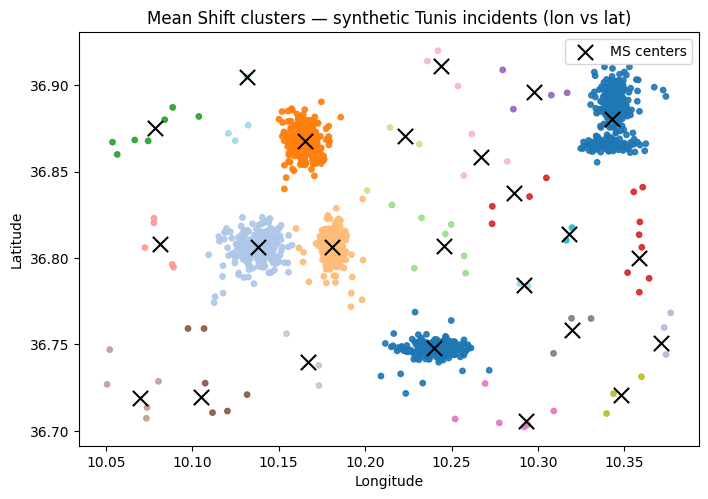

In [8]:
# 6) Static scatter visualization (matplotlib)
plt.figure(figsize=(8,8))
scatter = plt.scatter(df["lon"], df["lat"], c=df["ms_label"], cmap="tab20", s=15, alpha=0.9)
plt.scatter(cluster_centers[:,1], cluster_centers[:,0], c="black", s=120, marker="x", label="MS centers")
plt.title("Mean Shift clusters — synthetic Tunis incidents (lon vs lat)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [9]:
# 7) Interactive Folium map showing clusters (one color per MS cluster)
# center map on Tunis
map_center = [36.8065, 10.1815]
m = folium.Map(location=map_center, zoom_start=12)

# Create a marker cluster for each MeanShift cluster label
colors = [
    'red','blue','green','purple','orange','darkred','lightred','beige','darkblue','darkgreen',
    'cadetblue','pink','lightblue','lightgreen','gray','black','brown','lightgray'
]
# map numeric labels to colors (wrap if many)
label_to_color = {lbl: colors[i % len(colors)] for i, lbl in enumerate(sorted(df['ms_label'].unique()))}

marker_cluster = MarkerCluster().add_to(m)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color=label_to_color[row["ms_label"]],
        fill=True,
        fill_opacity=0.8
    ).add_to(marker_cluster)

# Add cluster centers
for i, (c_lat, c_lon) in enumerate(cluster_centers):
    folium.Marker(
        location=[c_lat, c_lon],
        icon=folium.Icon(color='black', icon='info-sign'),
        tooltip=f"MS center {i}"
    ).add_to(m)

# Save map to HTML
m.save("tunisia_synthetic_crime_mean_shift_map.html")
print("Map saved: tunisia_synthetic_crime_mean_shift_map.html")

Map saved: tunisia_synthetic_crime_mean_shift_map.html
